In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import datasets, transforms

In [2]:
#hyper parameters
EPOCH = 1
BATCH_SIZE = 64
LR_G = 0.0001
LR_D = 0.0001

In [47]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

#loading the dataset
data_train = datasets.CIFAR10(root="./datasets", download=False,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
data_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True)
print(data_loader.dataset.data.shape)

GPU State: cpu
(50000, 32, 32, 3)


In [67]:
print(data_loader.dataset.data.shape)

(50000, 32, 32, 3)


In [97]:
def showImg(imgs):
    sqrtn = int(np.ceil(np.sqrt(imgs.shape[0])))
    for index, img in enumerate(imgs):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(img.reshape(32, 32, 3).astype('uint8'))
        plt.axis(False)
    plt.show()
# showImg(data_loader.dataset.data[:16])

In [85]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1024*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [86]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024*3)
        )

    def forward(self, z):
        return self.model(z)

In [87]:
D = Discriminator().to(device)
G = Generator().to(device)
loss_f = nn.MSELoss().to(device)
D_optim = torch.optim.Adam(D.parameters(), lr=LR_D)
G_optim = torch.optim.Adam(G.parameters(), lr=LR_G)
print(D)
print(G)
print(loss_f)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=3072, bias=True)
  )
)
MSELoss()


In [92]:
print(prob_real.size())
print(ones.size())

torch.Size([64, 3])
torch.Size([192, 1])


start epoch 0...


C:\Users\user\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([64, 3])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/1, 0/782, D_loss: 0.251  G_loss: 0.559
0/1, 100/782, D_loss: 0.050  G_loss: 0.815
0/1, 200/782, D_loss: 0.029  G_loss: 0.935
0/1, 300/782, D_loss: 0.000  G_loss: 0.999
0/1, 400/782, D_loss: 0.001  G_loss: 0.998
0/1, 500/782, D_loss: 0.007  G_loss: 0.989
0/1, 600/782, D_loss: 0.003  G_loss: 0.989
0/1, 700/782, D_loss: 0.000  G_loss: 0.999


C:\Users\user\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([16, 3])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: cannot reshape array of size 3072 into shape (32,32)

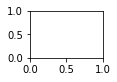

In [93]:
for epoch in range(EPOCH):
    print('start epoch {}...'.format(epoch))
    for i, (img, label) in enumerate(data_loader):
        batch_size = img.shape[0]
        
        z = torch.randn(batch_size, 100)
        
        real_img = img.view(-1, 1024*3)
        fake_img = G(z)
        
        ones = torch.ones(batch_size, 3)
        zeros = torch.zeros(batch_size, 3)
        
        #Discriminator
        prob_real = D(real_img)
        prob_fake = D(fake_img)
        
        D_loss_real = loss_f(prob_real, ones)
        D_loss_fake = loss_f(prob_fake, zeros)
        D_loss = (D_loss_real + D_loss_fake) / 2
        
        #Generator
        G_loss = loss_f(D_loss_fake, ones)
        
        D_optim.zero_grad()
        D_loss.backward(retain_graph=True)      # reusing computational graph
        D_optim.step()

        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        
        
        if i % 100 == 0 or i == len(data_loader):
            print('{}/{}, {}/{}, D_loss: {:.3f}  G_loss: {:.3f}'.format(epoch, EPOCH, i, len(data_loader), D_loss.item(), G_loss.item()))
            pass
#     imgs_numpy = (fake_img.data.cpu().numpy()+1.0)/2.0
    imgs_numpy = (fake_img.data.cpu().numpy())
    showImg(imgs_numpy[:16])
    plt.show()
print('Done!!!')

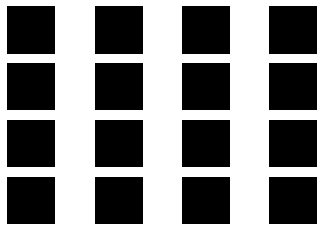

(16, 3072)
torch.Size([16, 3, 32, 32])


In [98]:
imgs_numpy = (fake_img.data.cpu().numpy())
showImg(imgs_numpy[:16])
plt.show()
print(imgs_numpy[:16].shape)
print(img.size())